# 13. Loop-based backtesting
Advantages:
* The trading logic is straightforward to code.
* You can do way more custom stuff more easily, such as stoplosses and takeprofits. I would have no idea how to implement these in vectorized backtesting.
* It resembles live trading.

Disadvantages:
* Slow
* Possible to introduce look-ahead bias. To avoid this, you should be very careful with which data you access. If a backtest looks very good, cross-check the entry/exits.

I want to make this backtester as simple as possible. However for some things, OOP makes things much easier. We will explain these objects first. However we will use way less OOP than my other github repo QS_Extended. 

All objects and helper functions are in the 'backtester' folder.

In [1]:
from datetime import datetime, date, time
from times import get_market_dates, get_market_calendar, last_trading_date_before
from data import get_data
from backtester.portfolio import Portfolio
import json
import pandas as pd

START_DATE = date(2024, 1, 1)
END_DATE = date(2024, 3, 1)

### The Portfolio object
This simulates a portfolio. When an order gets filled, the values within the portfolio are updated. Also, at the end of the day (or how often we wish), the portfolio logs itself. It also keeps track of all fills.

In [2]:
# INTRADAY BACKTESTER

# Initialize historical scanner, portfolio and calendar
with open("../data/output/dailyscreens/GAP_30PCT.json", "r") as f:
    G30 = json.load(f)

portfolio = Portfolio(START_DATE, initial_capital=10000)
calendar = get_market_calendar("datetime")

# Loop through all days
for day in get_market_dates(START_DATE, END_DATE):
    # Scan for gappers
    gappers_today = G30[day.isoformat()]
    if not gappers_today:
        continue

    # AT MARKET OPEN, calculate gaps and enter positions
    # Get data
    data = {}
    previous_close_dt = calendar.loc[last_trading_date_before(day), "regular_close"]
    market_open_dt = calendar.loc[day, "regular_open"]
    market_close_dt = calendar.loc[day, "regular_close"]
    for gapper in gappers_today:
        data[gapper] = get_data(
            gapper,
            previous_close_dt,
            market_close_dt,
            1,
            columns=["open", "close", "halted"],
        )

    # Calculate gaps
    gap = {}
    for gapper in gappers_today:
        # Get the top 3 largest gappers
        previous_close = data[gapper].loc[previous_close_dt, "close"]
        current_open = data[gapper].loc[market_open_dt, "open"]
        gap[gapper] = current_open / previous_close

    sorted_gap = sorted(gap.items(), key=lambda x: x[1], reverse=True)

    # Market order with 20% of cash
    size = portfolio.current_cash * 0.2
    for gapper in gappers_today:
        current_open = data[gapper].loc[market_open_dt, "open"]
        quantity = int(size / current_open)
        portfolio.update_from_fill(
            dt=market_open_dt,
            side="SELL",
            symbol=gapper,
            fill_quantity=quantity,
            fill_price=current_open,
            fees=5,
        )

    # TODO: Implement stoploss

    # AT MARKET CLOSE: close all positions, update portfolio
    for symbol, quantity in portfolio.current_positions.items():
        if quantity != 0:
            close_price = data[symbol].loc[market_close_dt, "close"]
            action = "SELL" if quantity > 0 else "BUY"
            portfolio.update_from_fill(
                dt=market_close_dt,
                side=action,
                symbol=symbol,
                fill_quantity=abs(quantity),
                fill_price=close_price,
                fees=5,
            )

    portfolio.append_portfolio_log(market_close_dt, data)

In [3]:
portfolio.get_df_from_fills_log()

,symbol,side,quantity,fill_price,fees
datetime,,,,,
2024-01-02 09:30:00,LBPH-2021-03-12,SELL,108,18.4800,5
2024-01-02 09:30:00,SGN-2023-11-13,SELL,1333,1.5000,5
2024-01-02 09:30:00,SNGX-2019-06-03,SELL,1960,1.0200,5
2024-01-02 15:59:00,LBPH-2021-03-12,BUY,108,25.1600,5
2024-01-02 15:59:00,SGN-2023-11-13,BUY,1333,1.0528,5
...,...,...,...,...,...
2024-02-29 15:59:00,COCH-2023-10-02,BUY,529,4.8500,5
2024-02-29 15:59:00,ENVB-2020-12-31,BUY,1110,1.4400,5
2024-02-29 15:59:00,JL-2024-01-24,BUY,83,1.9374,5


In [4]:
portfolio_log = portfolio.get_df_from_holdings_log()
portfolio_log.head(10)

,equity,cash,positions_value,positions,return,return_cum
datetime,,,,,,
2024-01-01,10000.000,10000.000,0,{},0.000,0.000
2024-01-02 15:59:00,10175.918,10175.918,0,"{'LBPH-2021-03-12': 0, 'SGN-2023-11-13': 0, 'S...",1.759,1.759
2024-01-03 15:59:00,11170.156,11170.156,0,"{'LBPH-2021-03-12': 0, 'SGN-2023-11-13': 0, 'S...",9.770,11.702
2024-01-04 15:59:00,12033.554,12033.554,0,"{'LBPH-2021-03-12': 0, 'SGN-2023-11-13': 0, 'S...",7.730,20.336
2024-01-05 15:59:00,13104.644,13104.644,0,"{'LBPH-2021-03-12': 0, 'SGN-2023-11-13': 0, 'S...",8.901,31.046
2024-01-08 15:59:00,15031.353,15031.353,0,"{'LBPH-2021-03-12': 0, 'SGN-2023-11-13': 0, 'S...",14.702,50.314
2024-01-09 15:59:00,16181.609,16181.609,0,"{'LBPH-2021-03-12': 0, 'SGN-2023-11-13': 0, 'S...",7.652,61.816
2024-01-10 15:59:00,17076.249,17076.249,0,"{'LBPH-2021-03-12': 0, 'SGN-2023-11-13': 0, 'S...",5.529,70.762
2024-01-11 15:59:00,17618.569,17618.569,0,"{'LBPH-2021-03-12': 0, 'SGN-2023-11-13': 0, 'S...",3.176,76.186


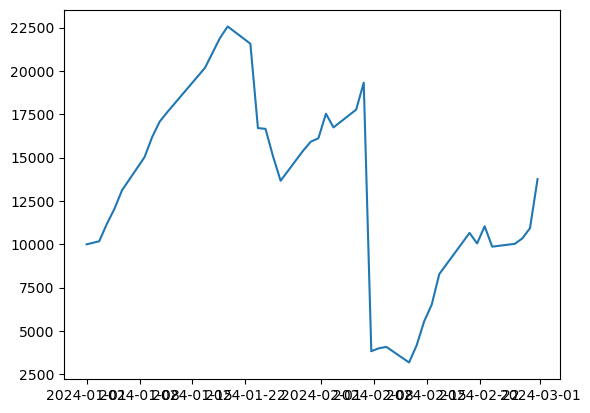

In [5]:
from matplotlib import pyplot as plt
plt.plot(portfolio_log.index, portfolio_log.equity)
plt.show()

I am going to show the flexibility and will backtest the following systems:
* Pre-market gap short with 10% stoploss and hold to EOD
* IBS strategy on SPY, with realistic entries (that is, not exactly at market close but 1 minute before)
* Every week, buy the 5 stocks in the T500 that have the largest distance to the moving average